# `CNRatioModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioModel` models both ${\rm CN}$ and $^{13}{\rm CN}$ spectral simultaneously in order to constrain the isotopic ratio $^{12}{\rm C}/^{13}{\rm C}$.

The ratio parameter `12C_13C_ratio` is only equivalent to the "true" isotopic ratio under the assumption that both species have the same excitation conditions (i.e., the same population fraction in the $N=0$ and $N=1$ states). This parameter is equivalent to the total column density ratio of all $N=0$ and $N=1$ states, $N_{\rm tot, CN}/N_{{\rm tot}, ^{13}\rm CN}$ where $N_{\rm tot} = \sum N_{N=0} + N_{N=1}$.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.4
bayes_cn_hfs version: 1.1.1+6.g94944ab.dirty


## Simulate Data

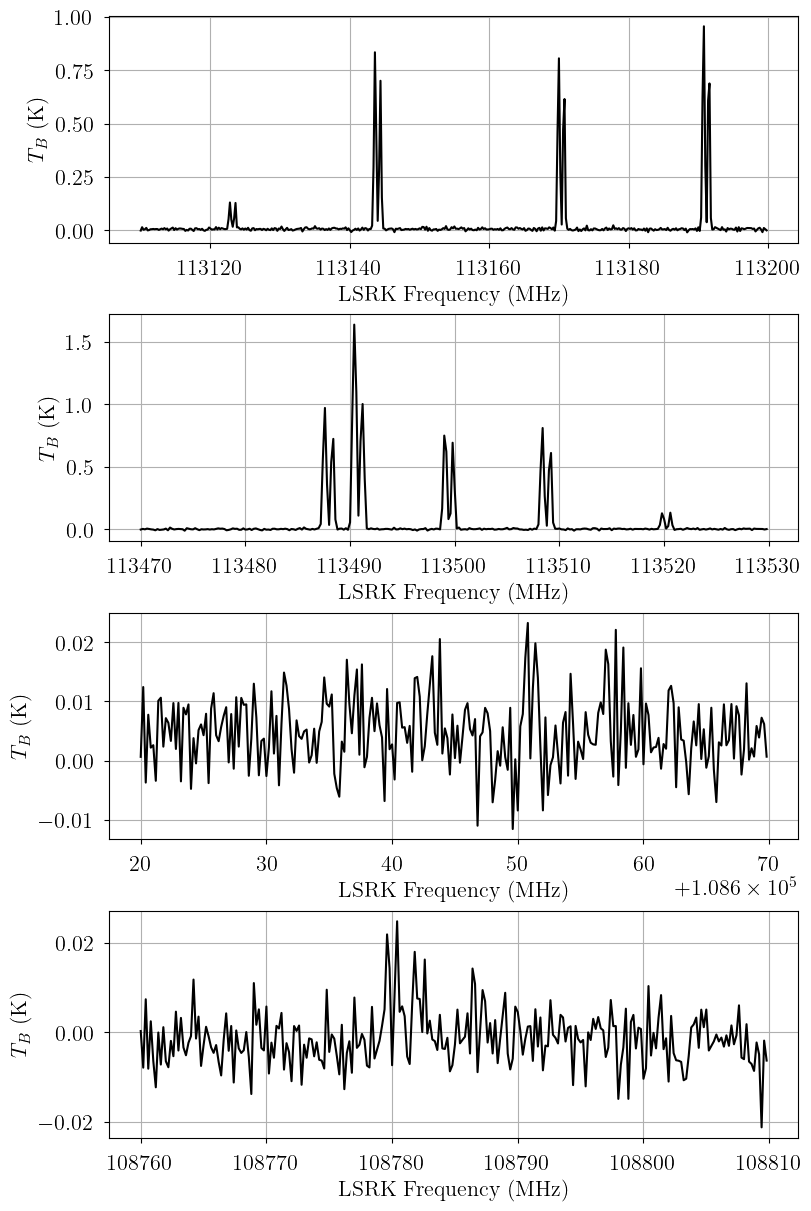

In [8]:
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.005 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.5, 1.0], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N_12CN": [13.9, 13.8],
    "ratio_12C_13C": [65.0, 55.0],
    "log10_Tkin": [0.6, 0.7],
    "velocity": [-0.5, 1.5],
    "fwhm_nonthermal": [0.5, 0.75],
    "fwhm_L": 0.0,
    "baseline_12CN_norm": [0.0],
    "baseline_13CN_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

In [9]:
sim_params

{'log10_N_12CN': [13.9, 13.8],
 'ratio_12C_13C': [65.0, 55.0],
 'log10_Tkin': [0.6, 0.7],
 'velocity': [-0.5, 1.5],
 'fwhm_nonthermal': [0.5, 0.75],
 'fwhm_L': 0.0,
 'baseline_12CN_norm': [0.0],
 'baseline_13CN_norm': [0.0],
 'fwhm_thermal_12CN': array([0.08371703, 0.09393205]),
 'fwhm_thermal_13CN': array([0.08215209, 0.09217616]),
 'fwhm_12CN': array([0.5069601 , 0.75585927]),
 'fwhm_13CN': array([0.50670402, 0.75564307]),
 'N_13CN': array([1.22204344e+12, 1.14719517e+12]),
 'log10_Tex_ul': array([0.6, 0.7]),
 'Tex_12CN': array([[3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234]]),
 'tau_12CN': array([[0.03961643, 0.02451991],
        [0.32429648, 0.20071051],
        [0.31672379, 0.19603779],
        [0.41128963, 0.25456059],
        [0.4128

## Model Definition

In [10]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.5, 1.0], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

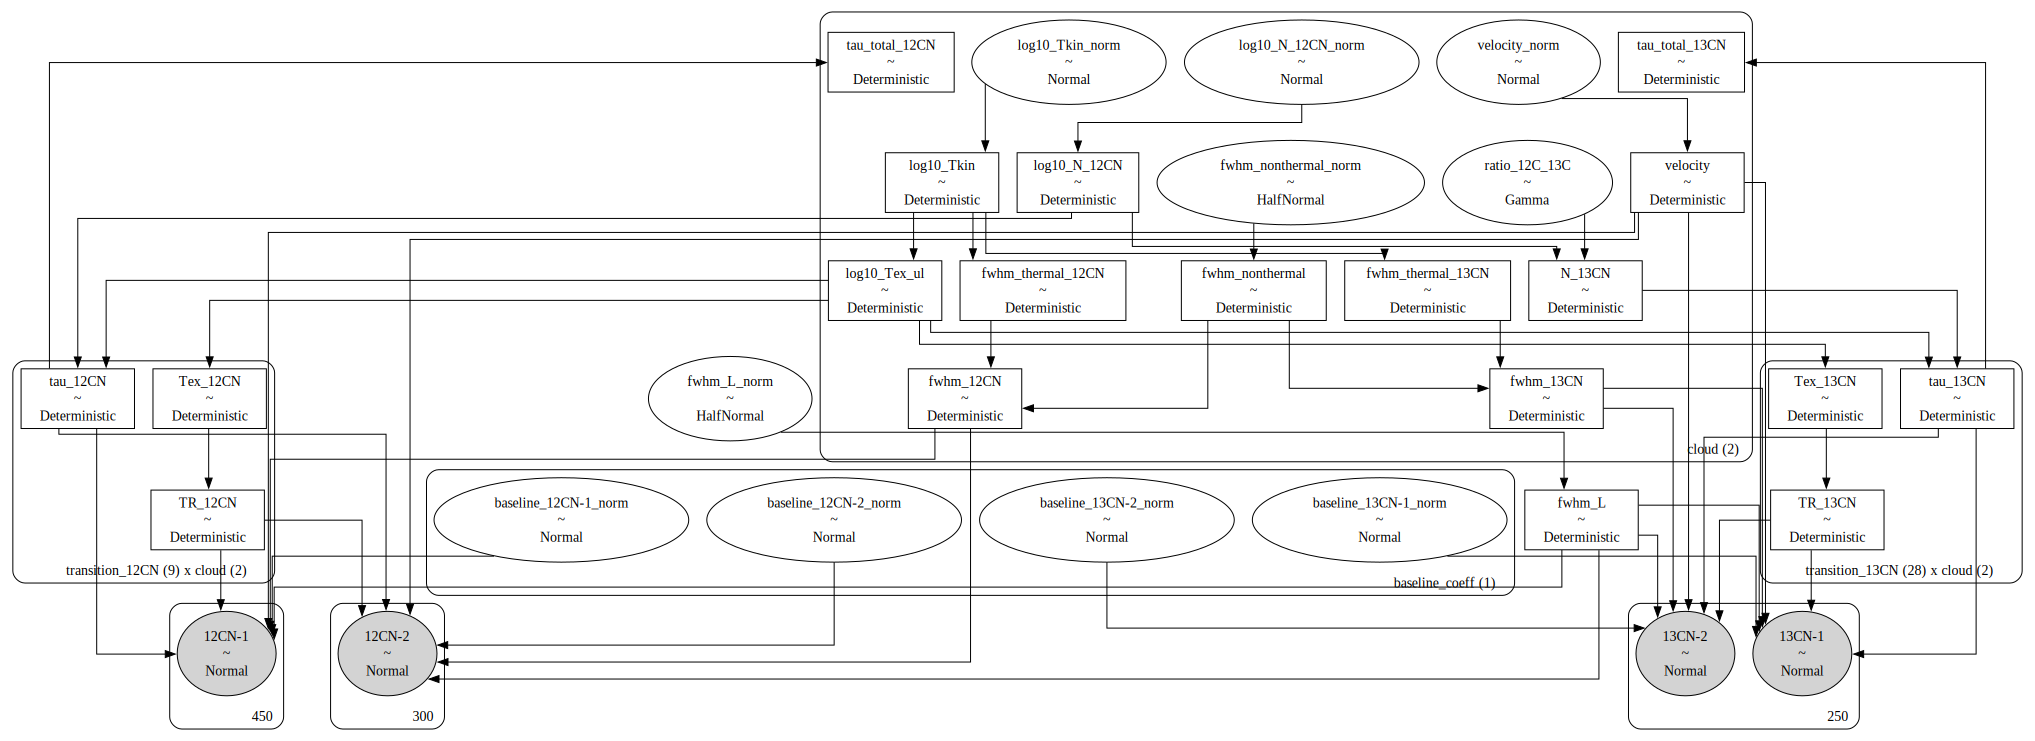

In [11]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [12]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, 1)
baseline_12CN-2_norm ~ Normal(0, 1)
baseline_13CN-1_norm ~ Normal(0, 1)
baseline_13CN-2_norm ~ Normal(0, 1)
       velocity_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
         fwhm_L_norm ~ HalfNormal(0, 1)
   log10_N_12CN_norm ~ Normal(0, 1)
       ratio_12C_13C ~ Gamma(9, f())
            velocity ~ Deterministic(f(velocity_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
   fwhm_thermal_12CN ~ Deterministic(f(log10_Tkin_norm))
   fwhm_thermal_13CN ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
           fwhm_12CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
           fwhm_13CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
              fwhm_L ~ Deterministic(f(fwhm_L_norm))
        log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
              N_13CN ~ Deterministic(f(ratio_12C_13C, log10_N_12CN_norm))

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tkin_norm, ratio_12C_13C, velocity_norm]


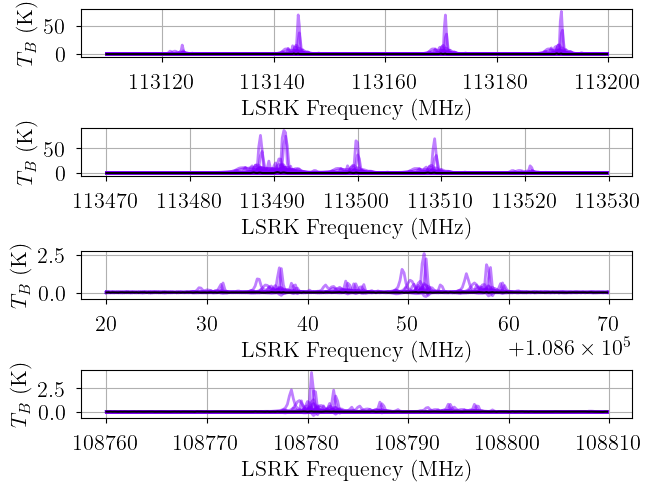

In [13]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm', 'baseline_13CN-1_norm', 'baseline_13CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_12CN_norm', 'ratio_12C_13C']
cloud_deterministics ['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'Tex_12CN', 'tau_12CN', 'tau_total_12CN', 'TR_12CN', 'Tex_13CN', 'tau_13CN', 'tau_total_13CN', 'TR_13CN']
hyper_freeRVs ['fwhm_L_norm']
hyper_deterministics ['fwhm_L']


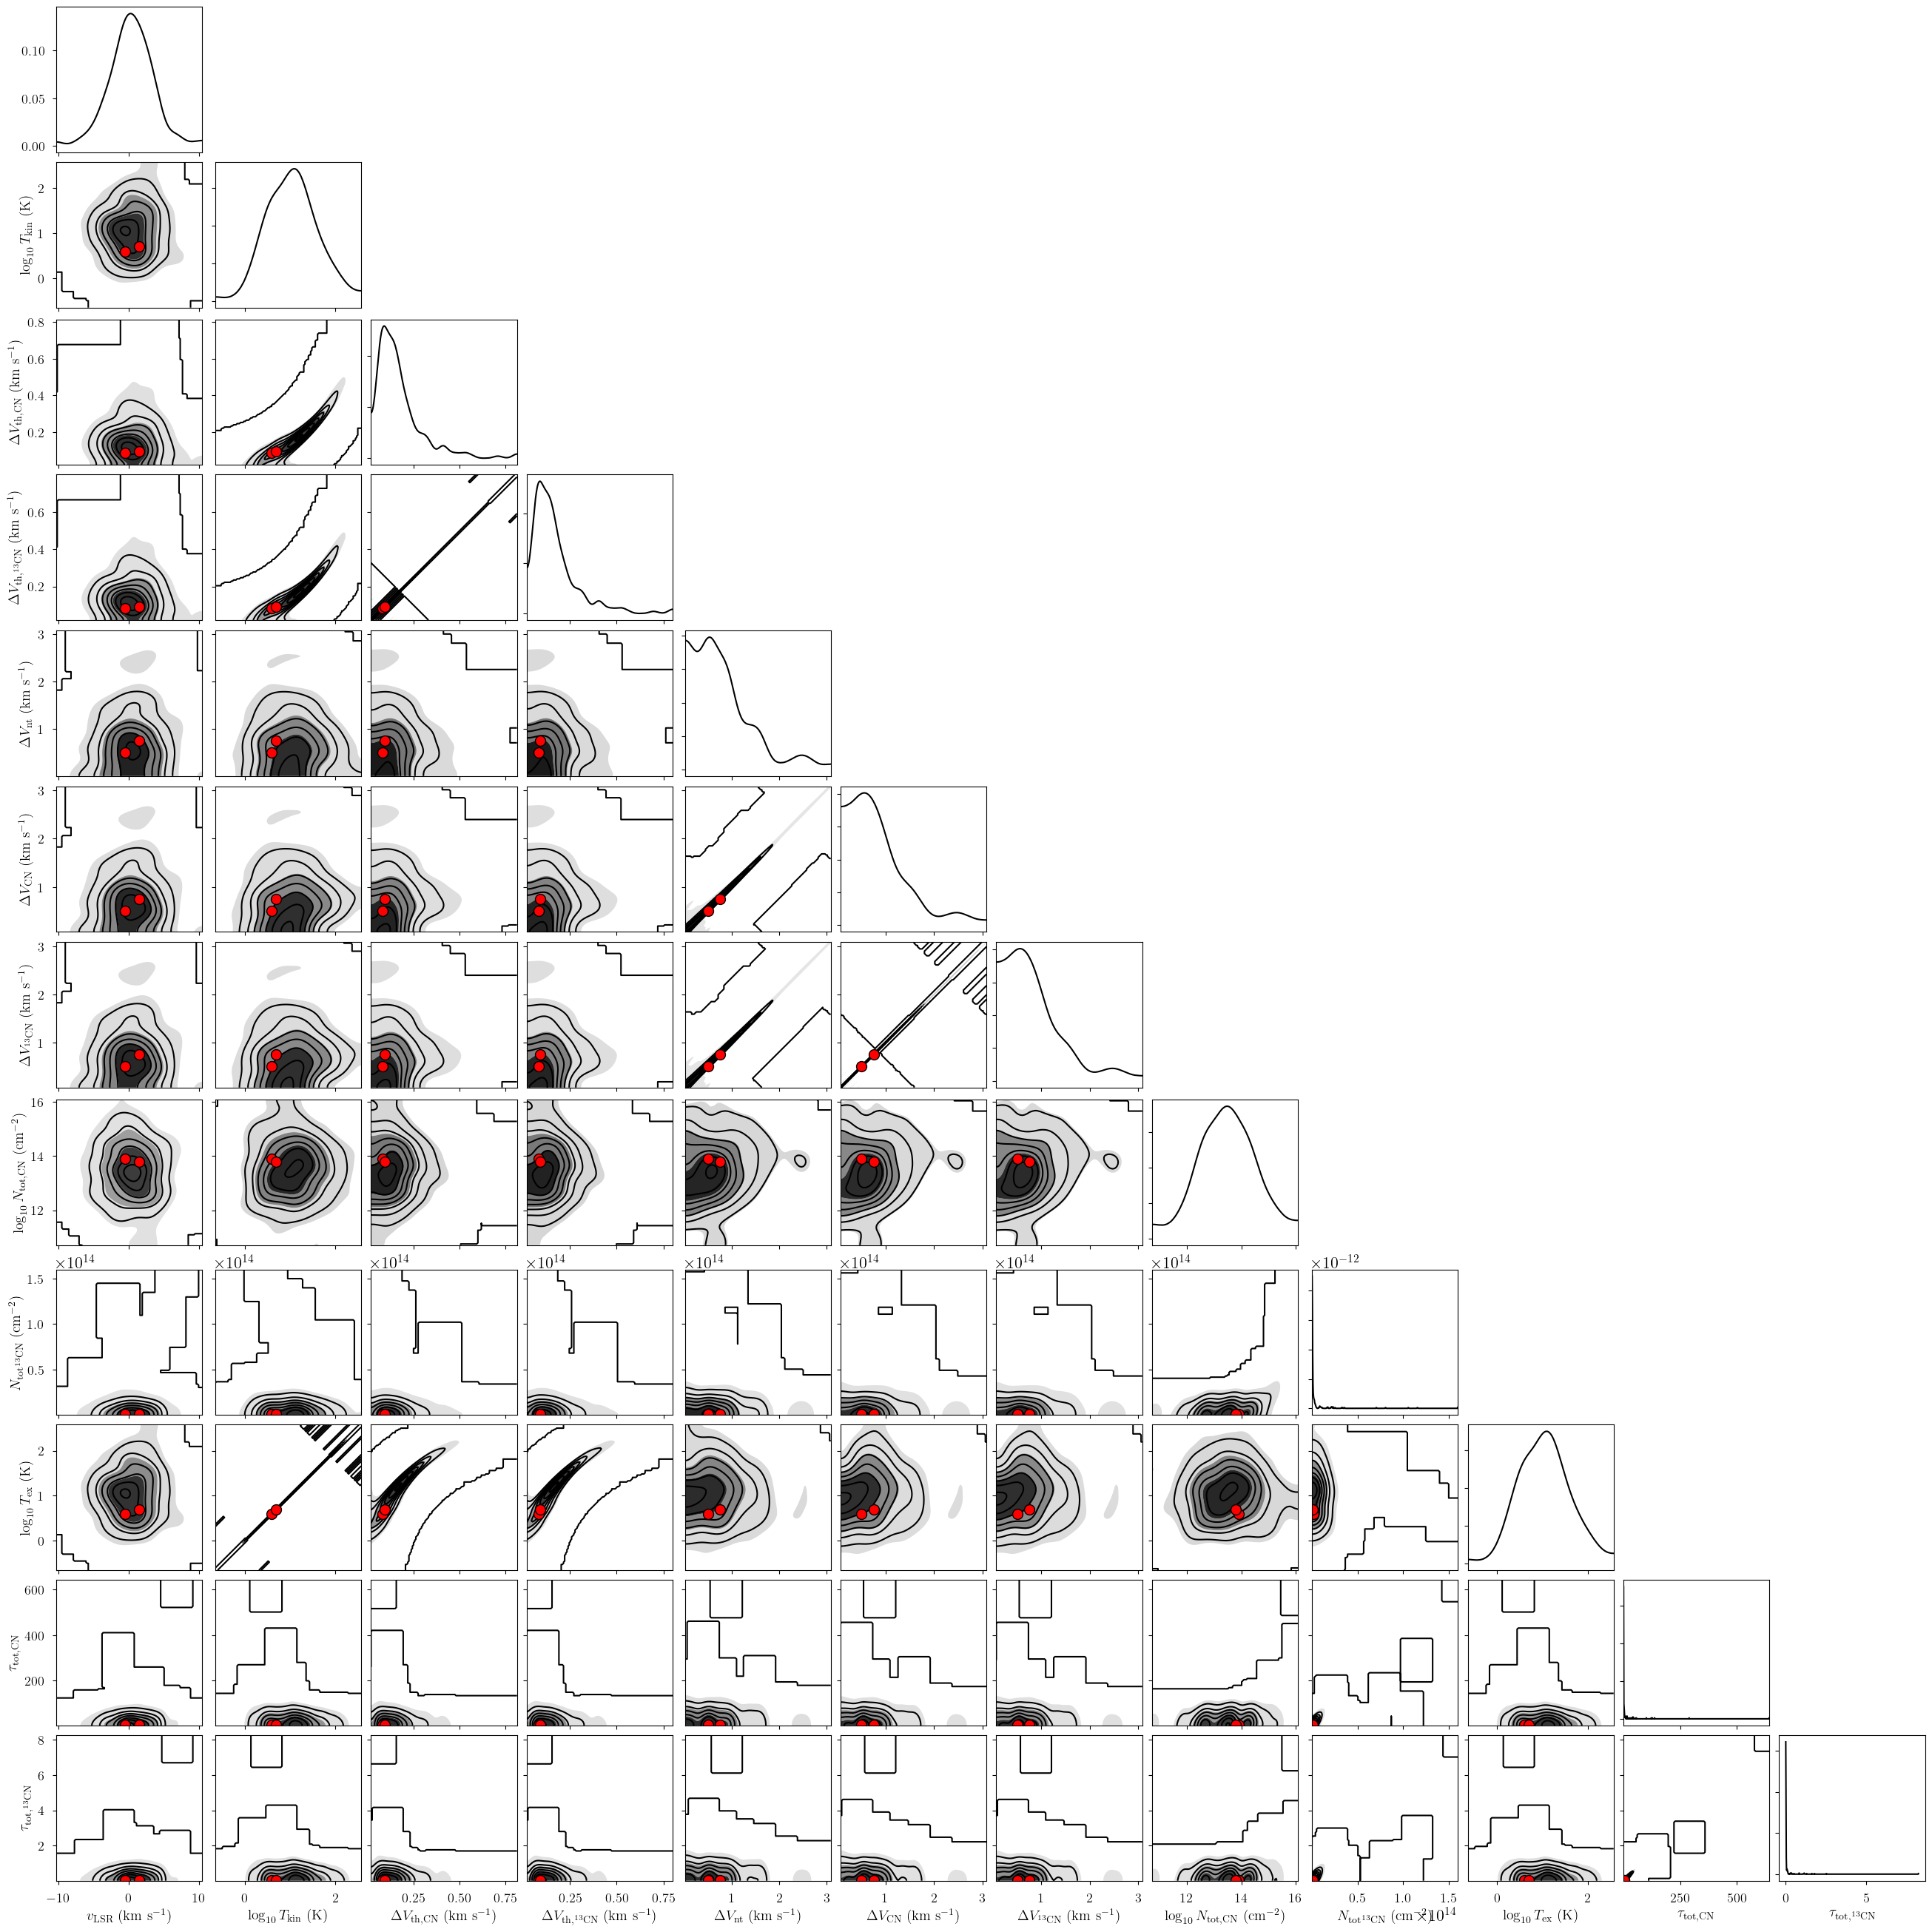

In [15]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [16]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 1.0501e+05


Output()

Runtime: 1.20 minutes


In [17]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean            sd        hdi_3%  \
velocity[0]             -4.870000e-01  1.000000e-03 -4.900000e-01   
velocity[1]              1.486000e+00  1.000000e-03  1.483000e+00   
log10_Tkin[0]            6.030000e-01  0.000000e+00  6.020000e-01   
log10_Tkin[1]            7.000000e-01  0.000000e+00  6.990000e-01   
fwhm_thermal_12CN[0]     8.400000e-02  0.000000e+00  8.400000e-02   
fwhm_thermal_12CN[1]     9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_13CN[0]     8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_thermal_13CN[1]     9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_nonthermal[0]       5.040000e-01  3.000000e-03  4.980000e-01   
fwhm_nonthermal[1]       7.420000e-01  3.000000e-03  7.370000e-01   
fwhm_12CN[0]             5.110000e-01  3.000000e-03  5.050000e-01   
fwhm_12CN[1]             7.480000e-01  3.000000e-03  7.430000e-01   
fwhm_13CN[0]             5.110000e-01  3.000000e-03  5.050000e-01   
fwhm_13CN[1]             7.470000e-01  3.000000e-03  7.420000e-01   
log10_N_12CN[0]          1.390800e+01  2.000000e-03  1.390400e+01   
log10_N_12CN[1]          1.380200e+01  1.000000e-03  1.380000e+01   
N_13CN[0]                1.090179e+12  1.222080e+11  8.676123e+11   
N_13CN[1]                9.830036e+11  9.710984e+10  8.113671e+11   
log10_Tex_ul[0]          6.030000e-01  0.000000e+00  6.020000e-01   
log10_Tex_ul[1]          7.000000e-01  0.000000e+00  6.990000e-01   
tau_total_12CN[0]        3.319000e+00  1.500000e-02  3.287000e+00   
tau_total_12CN[1]        2.044000e+00  6.000000e-03  2.034000e+00   
tau_total_13CN[0]        4.100000e-02  5.000000e-03  3.300000e-02   
tau_total_13CN[1]        2.900000e-02  3.000000e-03  2.400000e-02   
fwhm_L_norm              3.000000e-03  2.000000e-03  1.000000e-03   
fwhm_L                   3.000000e-03  2.000000e-03  1.000000e-03   
baseline_12CN-1_norm[0] -1.550000e-01  5.600000e-02 -2.480000e-01   
baseline_12CN-2_norm[0] -1.810000e-01  6.400000e-02 -3.000000e-01   
baseline_13CN-1_norm[0] -8.600000e-02  7.300000e-02 -2.220000e-01   
baseline_13CN-2_norm[0] -6.600000e-02  6.500000e-02 -1.760000e-01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]             -4.840000e-01  0.000000e+00  0.000000e+00     998.0   
velocity[1]              1.488000e+00  0.000000e+00  0.000000e+00     918.0   
log10_Tkin[0]            6.040000e-01  0.000000e+00  0.000000e+00     925.0   
log10_Tkin[1]            7.010000e-01  0.000000e+00  0.000000e+00    1013.0   
fwhm_thermal_12CN[0]     8.400000e-02  0.000000e+00  0.000000e+00     925.0   
fwhm_thermal_12CN[1]     9.400000e-02  0.000000e+00  0.000000e+00    1013.0   
fwhm_thermal_13CN[0]     8.300000e-02  0.000000e+00  0.000000e+00     925.0   
fwhm_thermal_13CN[1]     9.200000e-02  0.000000e+00  0.000000e+00    1013.0   
fwhm_nonthermal[0]       5.110000e-01  0.000000e+00  0.000000e+00     932.0   
fwhm_nonthermal[1]       7.470000e-01  0.000000e+00  0.000000e+00     890.0   
fwhm_12CN[0]             5.180000e-01  0.000000e+00  0.000000e+00     933.0   
fwhm_12CN[1]             7.530000e-01  0.000000e+00  0.000000e+00     889.0   
fwhm_13CN[0]             5.180000e-01  0.000000e+00  0.000000e+00     933.0   
fwhm_13CN[1]             7.530000e-01  0.000000e+00  0.000000e+00     889.0   
log10_N_12CN[0]          1.391100e+01  0.000000e+00  0.000000e+00    1023.0   
log10_N_12CN[1]          1.380400e+01  0.000000e+00  0.000000e+00     909.0   
N_13CN[0]                1.327859e+12  3.713294e+09  2.824032e+09    1090.0   
N_13CN[1]                1.167220e+12  3.347408e+09  2.070008e+09     843.0   
log10_Tex_ul[0]          6.040000e-01  0.000000e+00  0.000000e+00     925.0   
log10_Tex_ul[1]          7.010000e-01  0.000000e+00  0.000000e+00    1013.0   
tau_total_12CN[0]        3.345000e+00  0.000000e+00  0.000000e+00    1038.0   
tau_total_12CN[1]        2.056000e+00  0.000000e+00  0.000000e+00    1041.0   
tau_total_13CN[0]        5.000000e-02  0.000000e+00  0.000000e+00    1091.0 

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

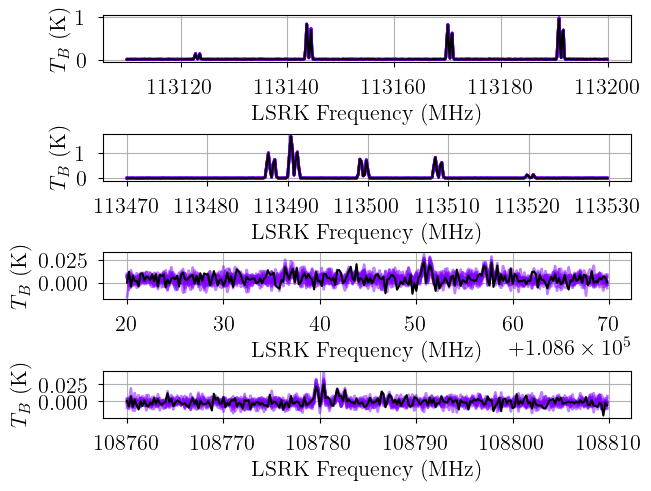

In [18]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [19]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 1.0501e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 126 seconds.


Adding log-likelihood to trace


Output()

Runtime: 2.99 minutes


In [20]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [21]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean            sd        hdi_3%  \
velocity[0]             -5.000000e-01  1.000000e-03 -5.010000e-01   
velocity[1]              1.501000e+00  1.000000e-03  1.499000e+00   
log10_Tkin[0]            6.000000e-01  1.000000e-03  5.990000e-01   
log10_Tkin[1]            6.990000e-01  1.000000e-03  6.970000e-01   
fwhm_thermal_12CN[0]     8.400000e-02  0.000000e+00  8.400000e-02   
fwhm_thermal_12CN[1]     9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_13CN[0]     8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_thermal_13CN[1]     9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_nonthermal[0]       5.010000e-01  3.000000e-03  4.950000e-01   
fwhm_nonthermal[1]       7.490000e-01  2.000000e-03  7.440000e-01   
fwhm_12CN[0]             5.080000e-01  3.000000e-03  5.020000e-01   
fwhm_12CN[1]             7.540000e-01  2.000000e-03  7.500000e-01   
fwhm_13CN[0]             5.080000e-01  3.000000e-03  5.020000e-01   
fwhm_13CN[1]             7.540000e-01  2.000000e-03  7.500000e-01   
log10_N_12CN[0]          1.390000e+01  4.000000e-03  1.389300e+01   
log10_N_12CN[1]          1.380100e+01  2.000000e-03  1.379600e+01   
N_13CN[0]                1.077461e+12  1.109476e+11  8.659113e+11   
N_13CN[1]                9.662530e+11  9.010680e+10  7.877857e+11   
log10_Tex_ul[0]          6.000000e-01  1.000000e-03  5.990000e-01   
log10_Tex_ul[1]          6.990000e-01  1.000000e-03  6.970000e-01   
tau_total_12CN[0]        3.286000e+00  3.400000e-02  3.220000e+00   
tau_total_12CN[1]        2.043000e+00  1.700000e-02  2.011000e+00   
tau_total_13CN[0]        4.100000e-02  4.000000e-03  3.300000e-02   
tau_total_13CN[1]        2.900000e-02  3.000000e-03  2.300000e-02   
fwhm_L                   2.000000e-03  2.000000e-03  0.000000e+00   
baseline_12CN-1_norm[0] -1.450000e-01  4.800000e-02 -2.330000e-01   
baseline_12CN-2_norm[0] -1.860000e-01  6.000000e-02 -2.950000e-01   
baseline_13CN-1_norm[0] -8.600000e-02  6.500000e-02 -2.100000e-01   
baseline_13CN-2_norm[0] -4.900000e-02  6.300000e-02 -1.660000e-01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]             -4.980000e-01  0.000000e+00  0.000000e+00   13499.0   
velocity[1]              1.503000e+00  0.000000e+00  0.000000e+00   12684.0   
log10_Tkin[0]            6.020000e-01  0.000000e+00  0.000000e+00    7942.0   
log10_Tkin[1]            7.010000e-01  0.000000e+00  0.000000e+00    7734.0   
fwhm_thermal_12CN[0]     8.400000e-02  0.000000e+00  0.000000e+00    7942.0   
fwhm_thermal_12CN[1]     9.400000e-02  0.000000e+00  0.000000e+00    7734.0   
fwhm_thermal_13CN[0]     8.200000e-02  0.000000e+00  0.000000e+00    7942.0   
fwhm_thermal_13CN[1]     9.200000e-02  0.000000e+00  0.000000e+00    7734.0   
fwhm_nonthermal[0]       5.070000e-01  0.000000e+00  0.000000e+00    9888.0   
fwhm_nonthermal[1]       7.530000e-01  0.000000e+00  0.000000e+00   11244.0   
fwhm_12CN[0]             5.140000e-01  0.000000e+00  0.000000e+00    9881.0   
fwhm_12CN[1]             7.590000e-01  0.000000e+00  0.000000e+00   11215.0   
fwhm_13CN[0]             5.140000e-01  0.000000e+00  0.000000e+00    9881.0   
fwhm_13CN[1]             7.590000e-01  0.000000e+00  0.000000e+00   11215.0   
log10_N_12CN[0]          1.390700e+01  0.000000e+00  0.000000e+00    7883.0   
log10_N_12CN[1]          1.380600e+01  0.000000e+00  0.000000e+00    7705.0   
N_13CN[0]                1.283317e+12  1.046205e+09  1.313102e+09   11123.0   
N_13CN[1]                1.127053e+12  8.305546e+08  1.115513e+09   11741.0   
log10_Tex_ul[0]          6.020000e-01  0.000000e+00  0.000000e+00    7942.0   
log10_Tex_ul[1]          7.010000e-01  0.000000e+00  0.000000e+00    7734.0   
tau_total_12CN[0]        3.348000e+00  0.000000e+00  0.000000e+00    7860.0   
tau_total_12CN[1]        2.075000e+00  0.000000e+00  0.000000e+00    7692.0   
tau_total_13CN[0]        4.900000e-02  0.000000e+00  0.000000e+00   11116.0   
tau_total_13CN[1]        3.300000e-02  0.000000e+00  0.000000e+00 

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

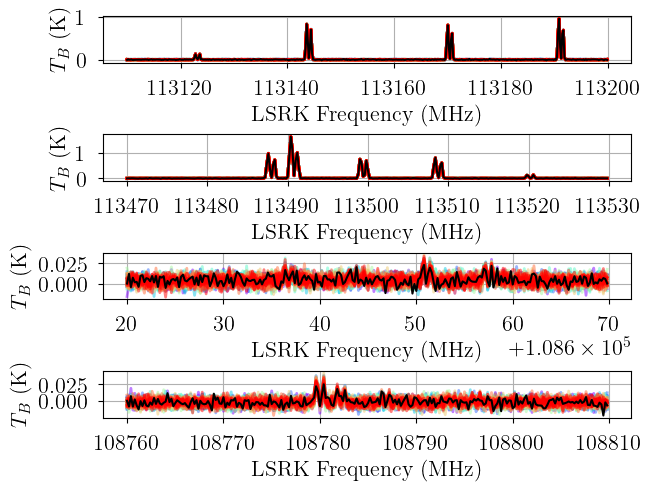

In [22]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

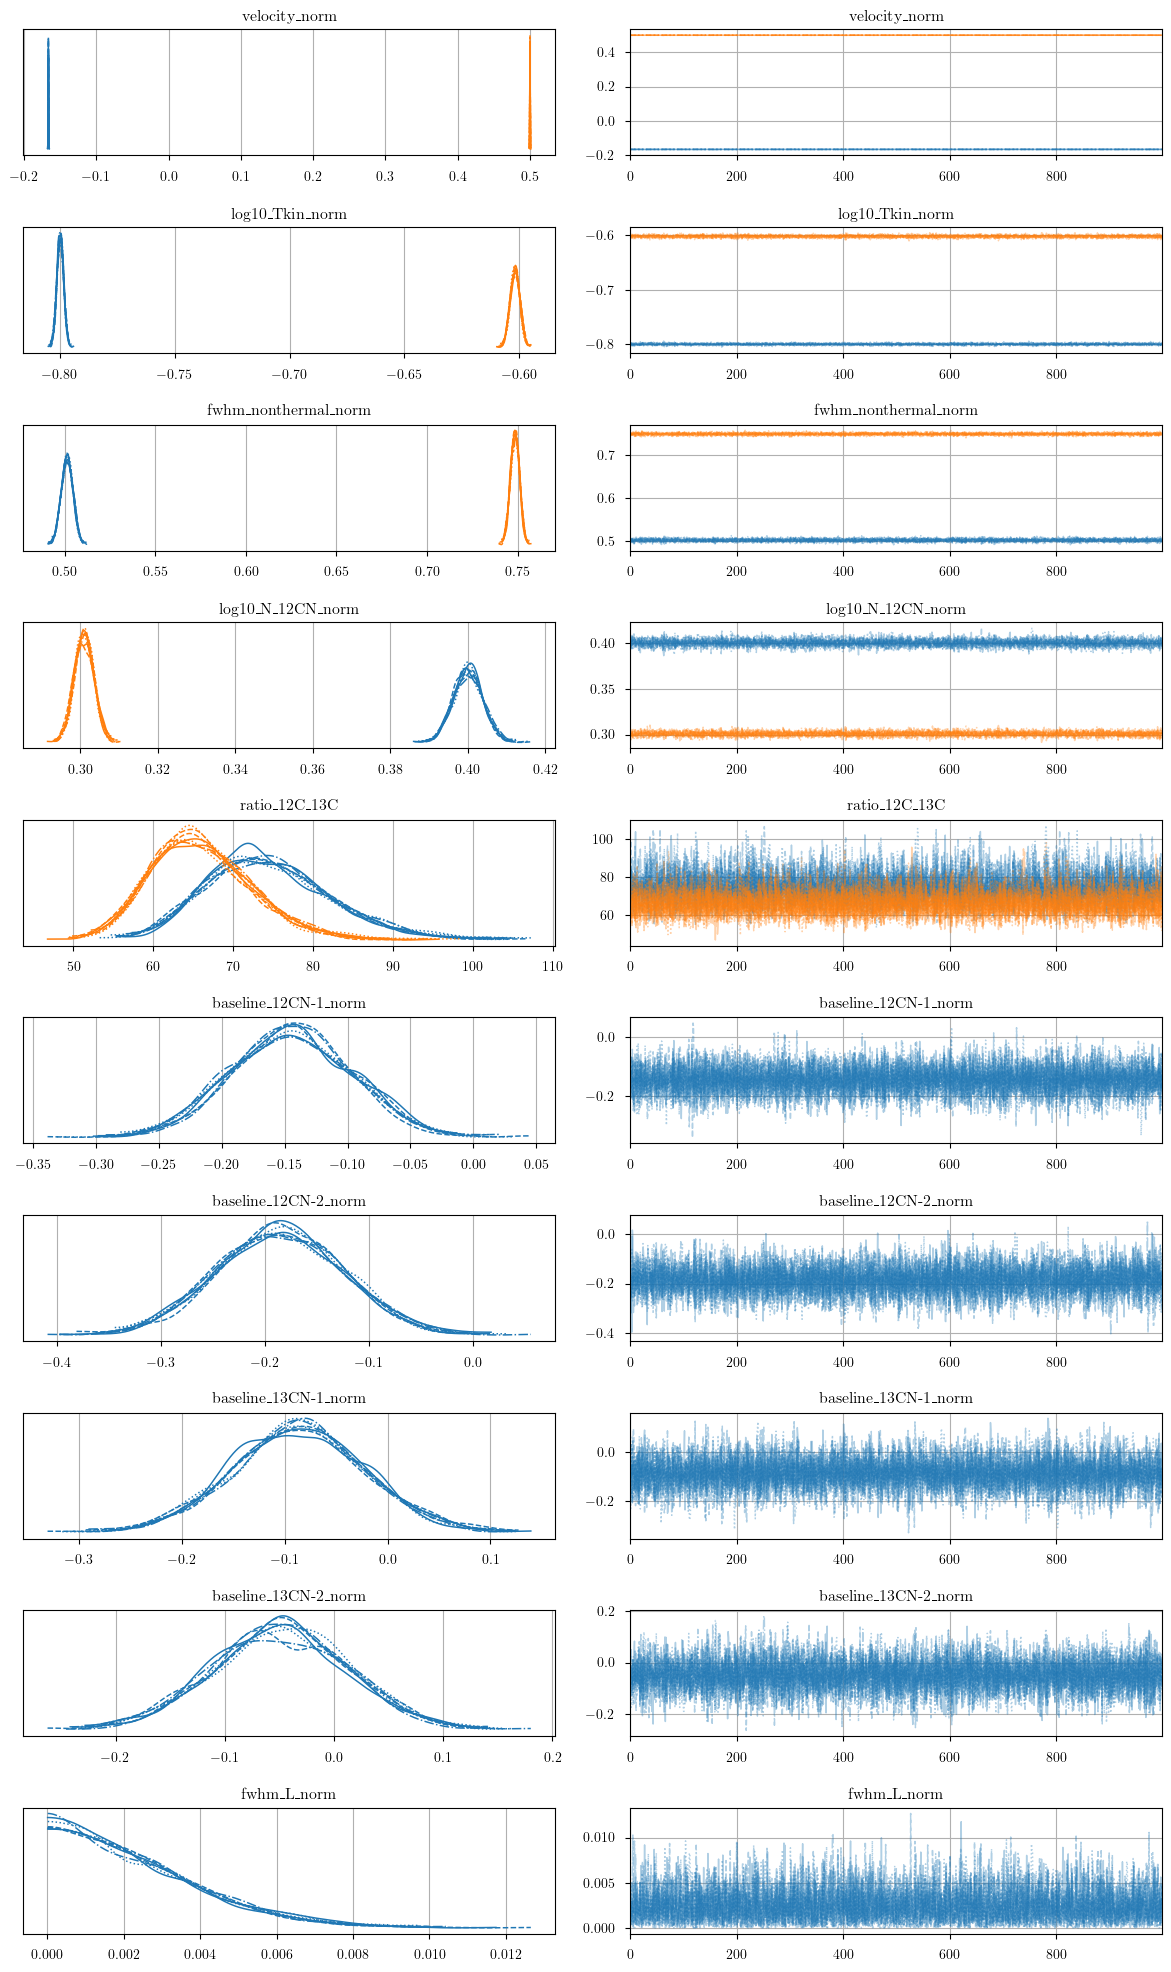

In [31]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

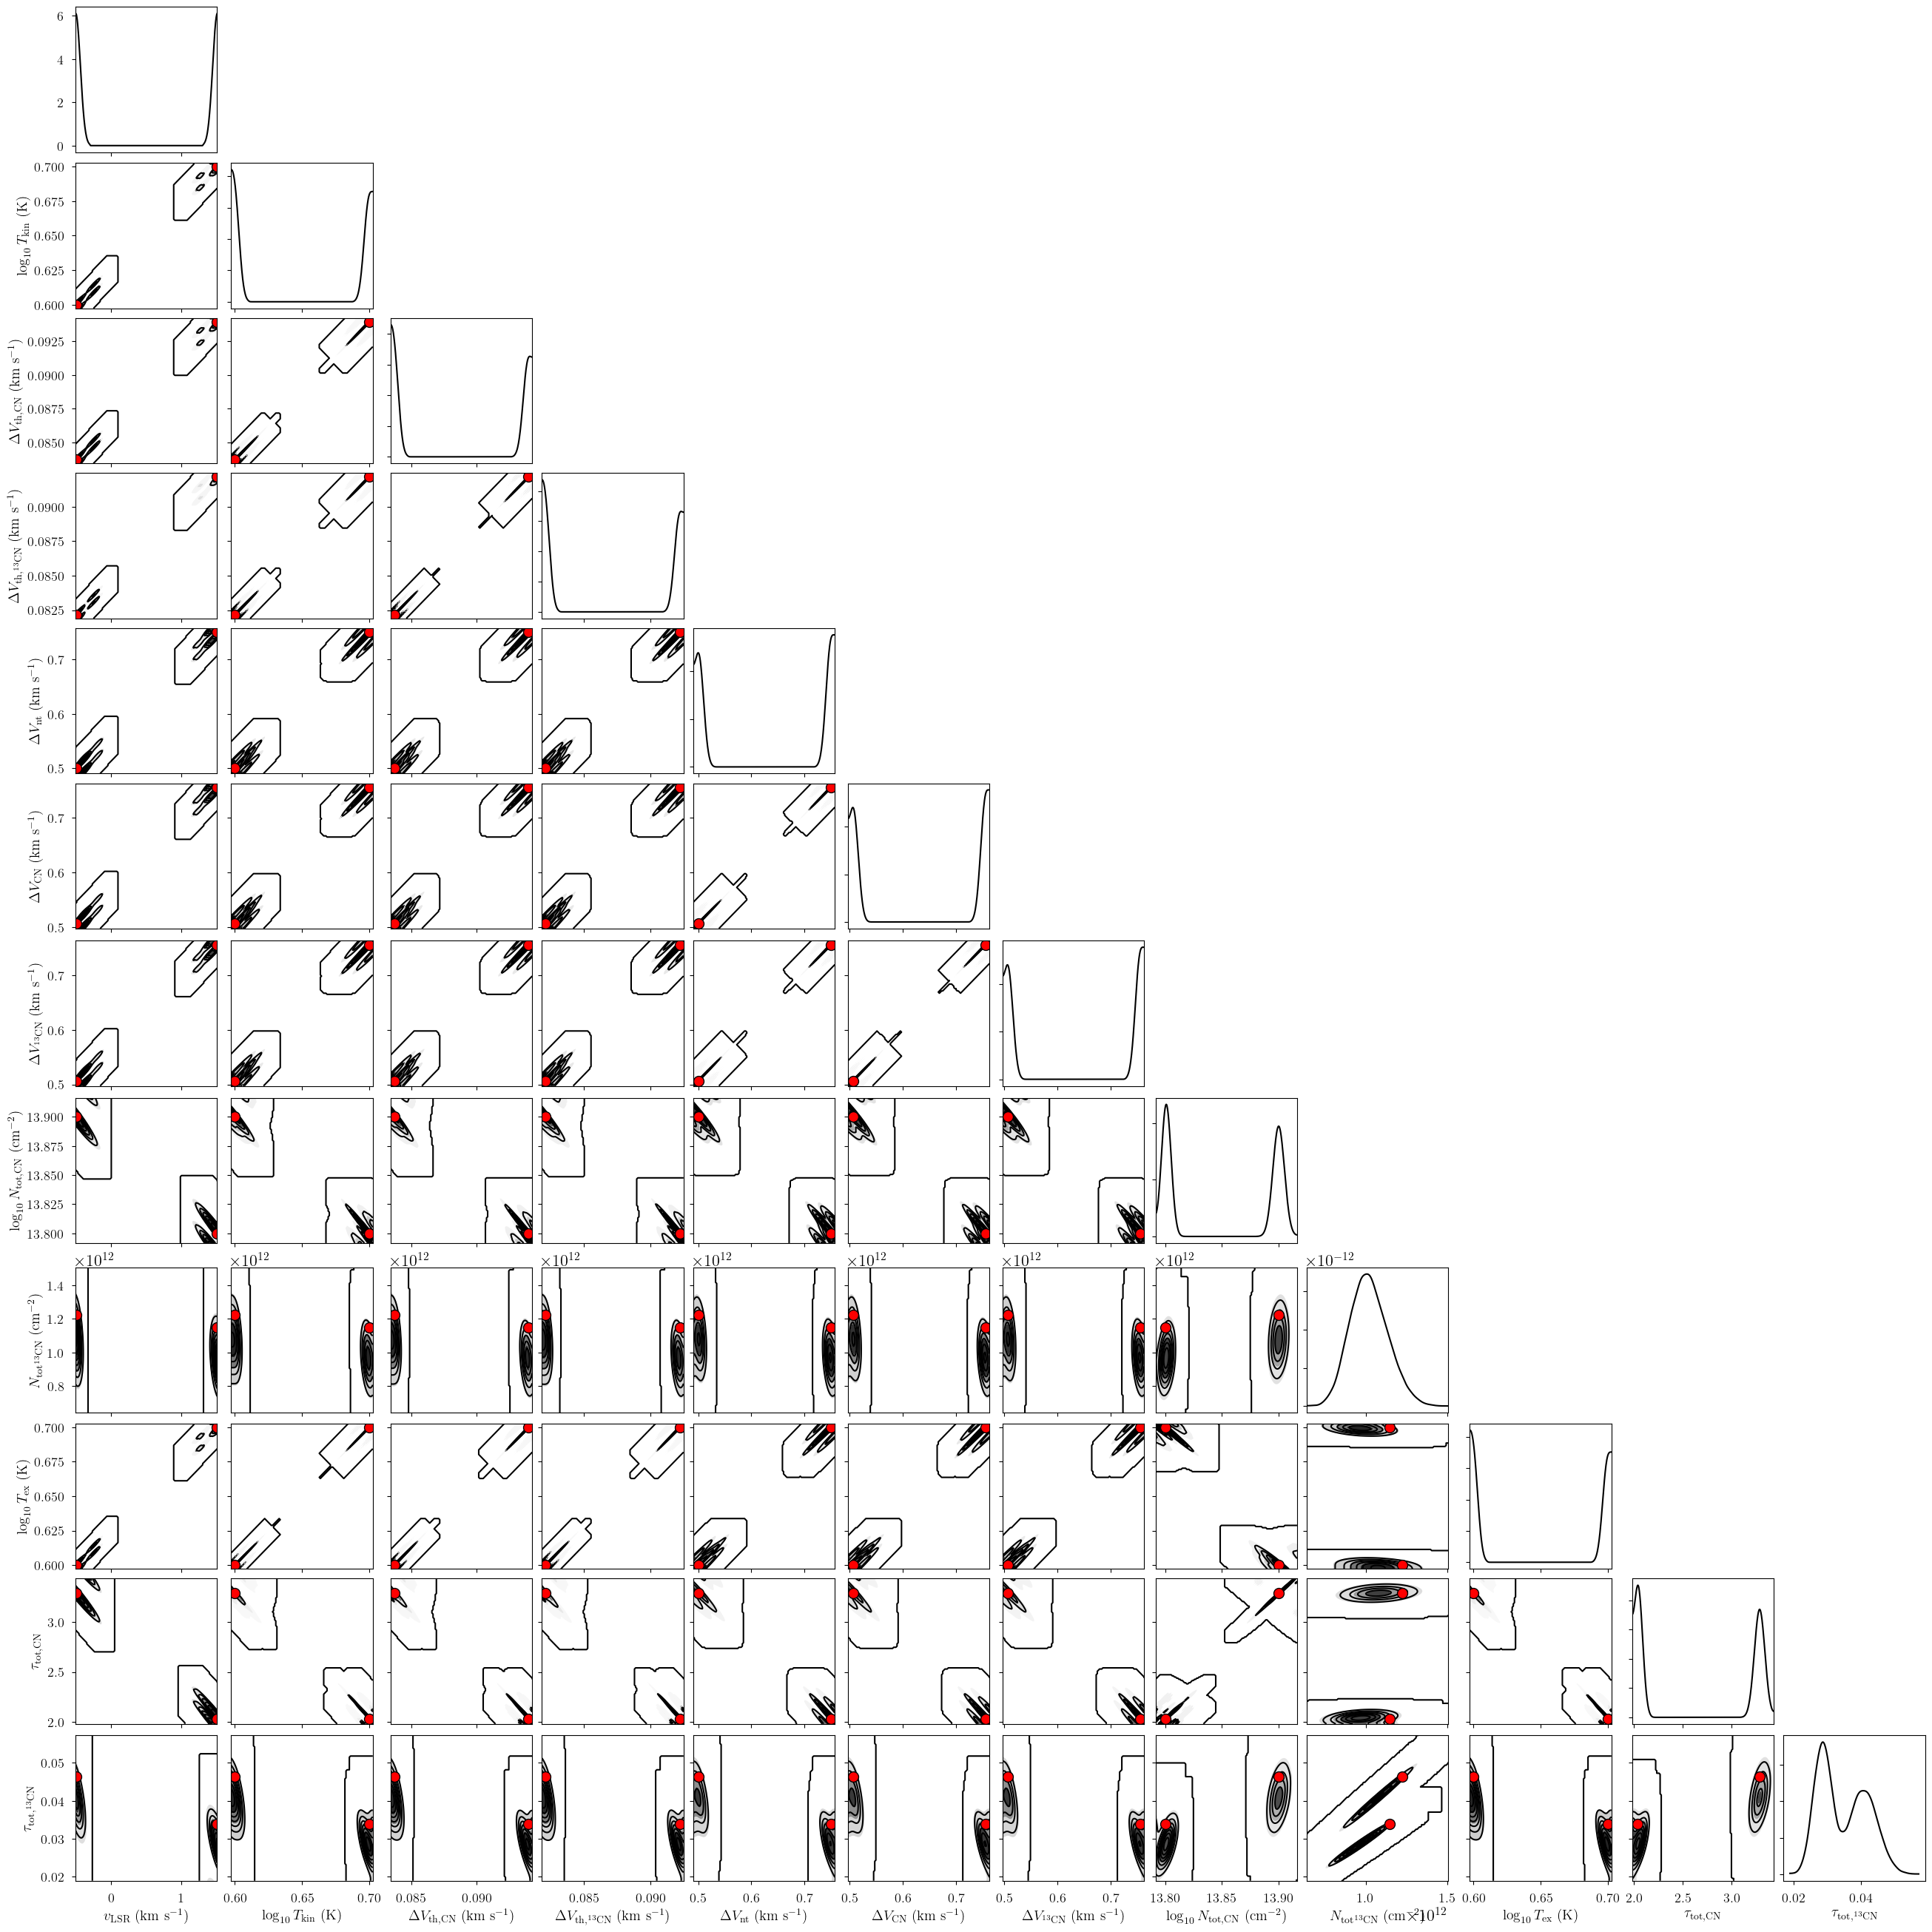

In [24]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN']


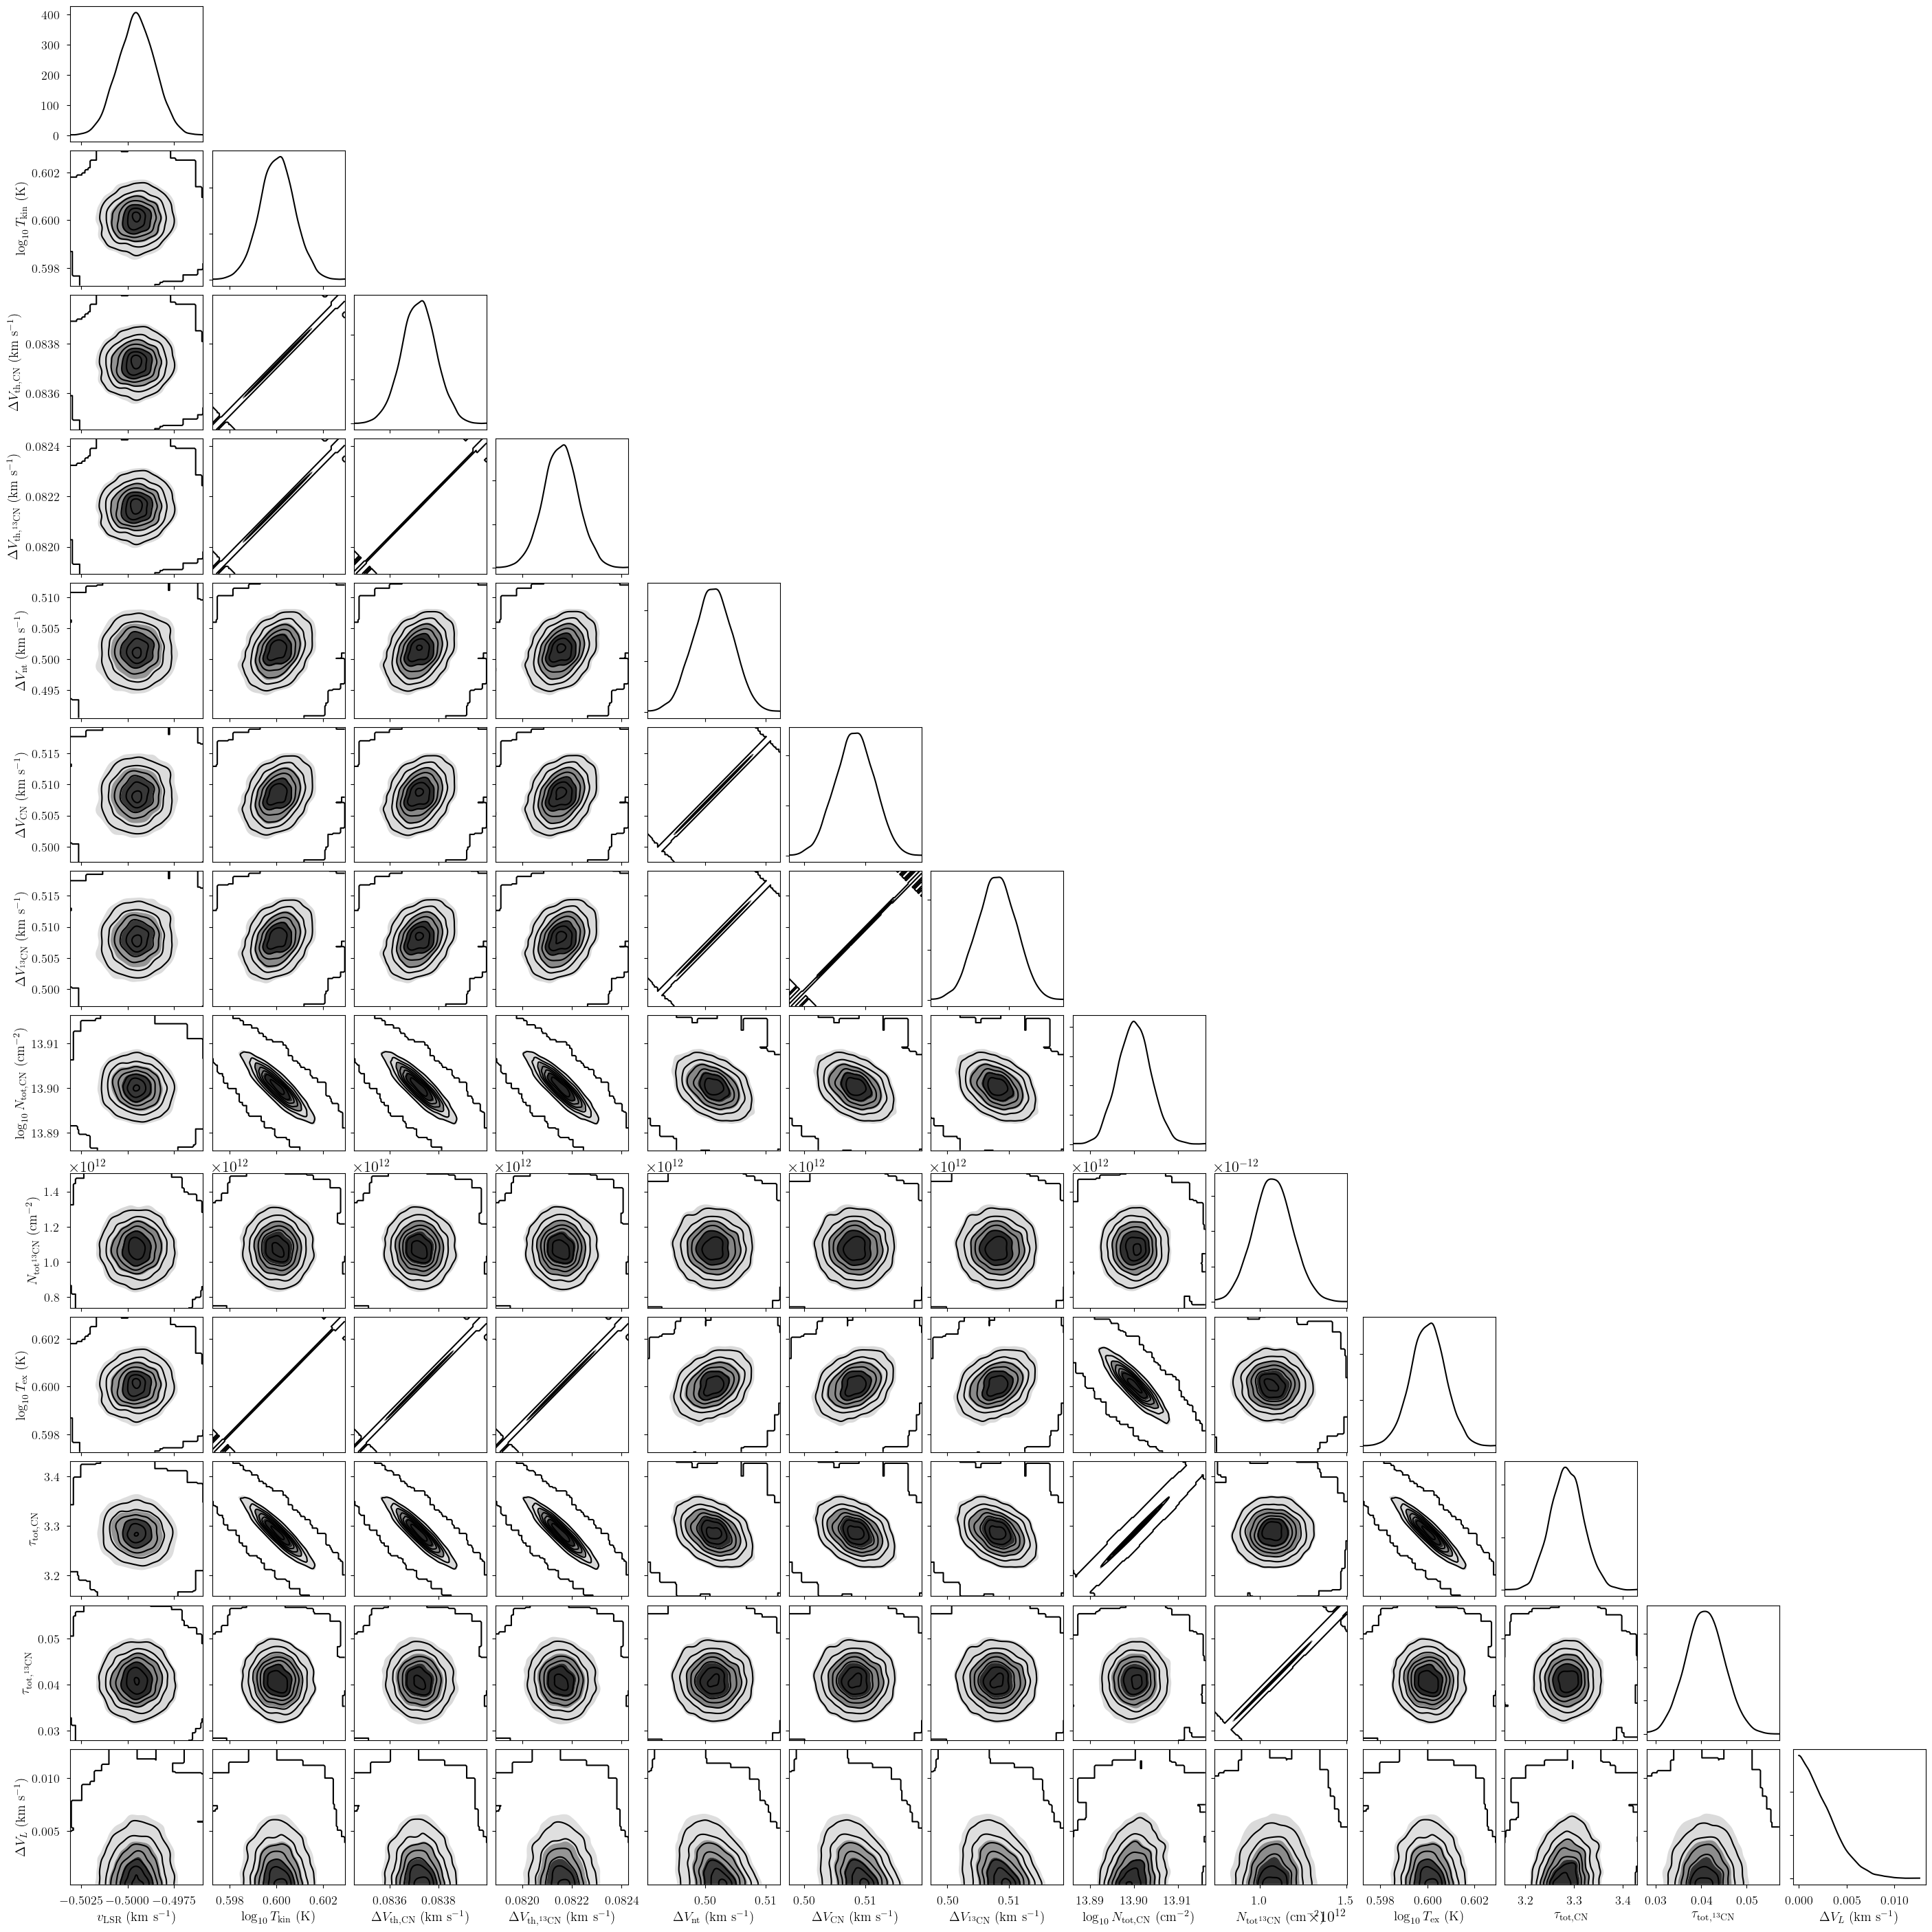

In [29]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

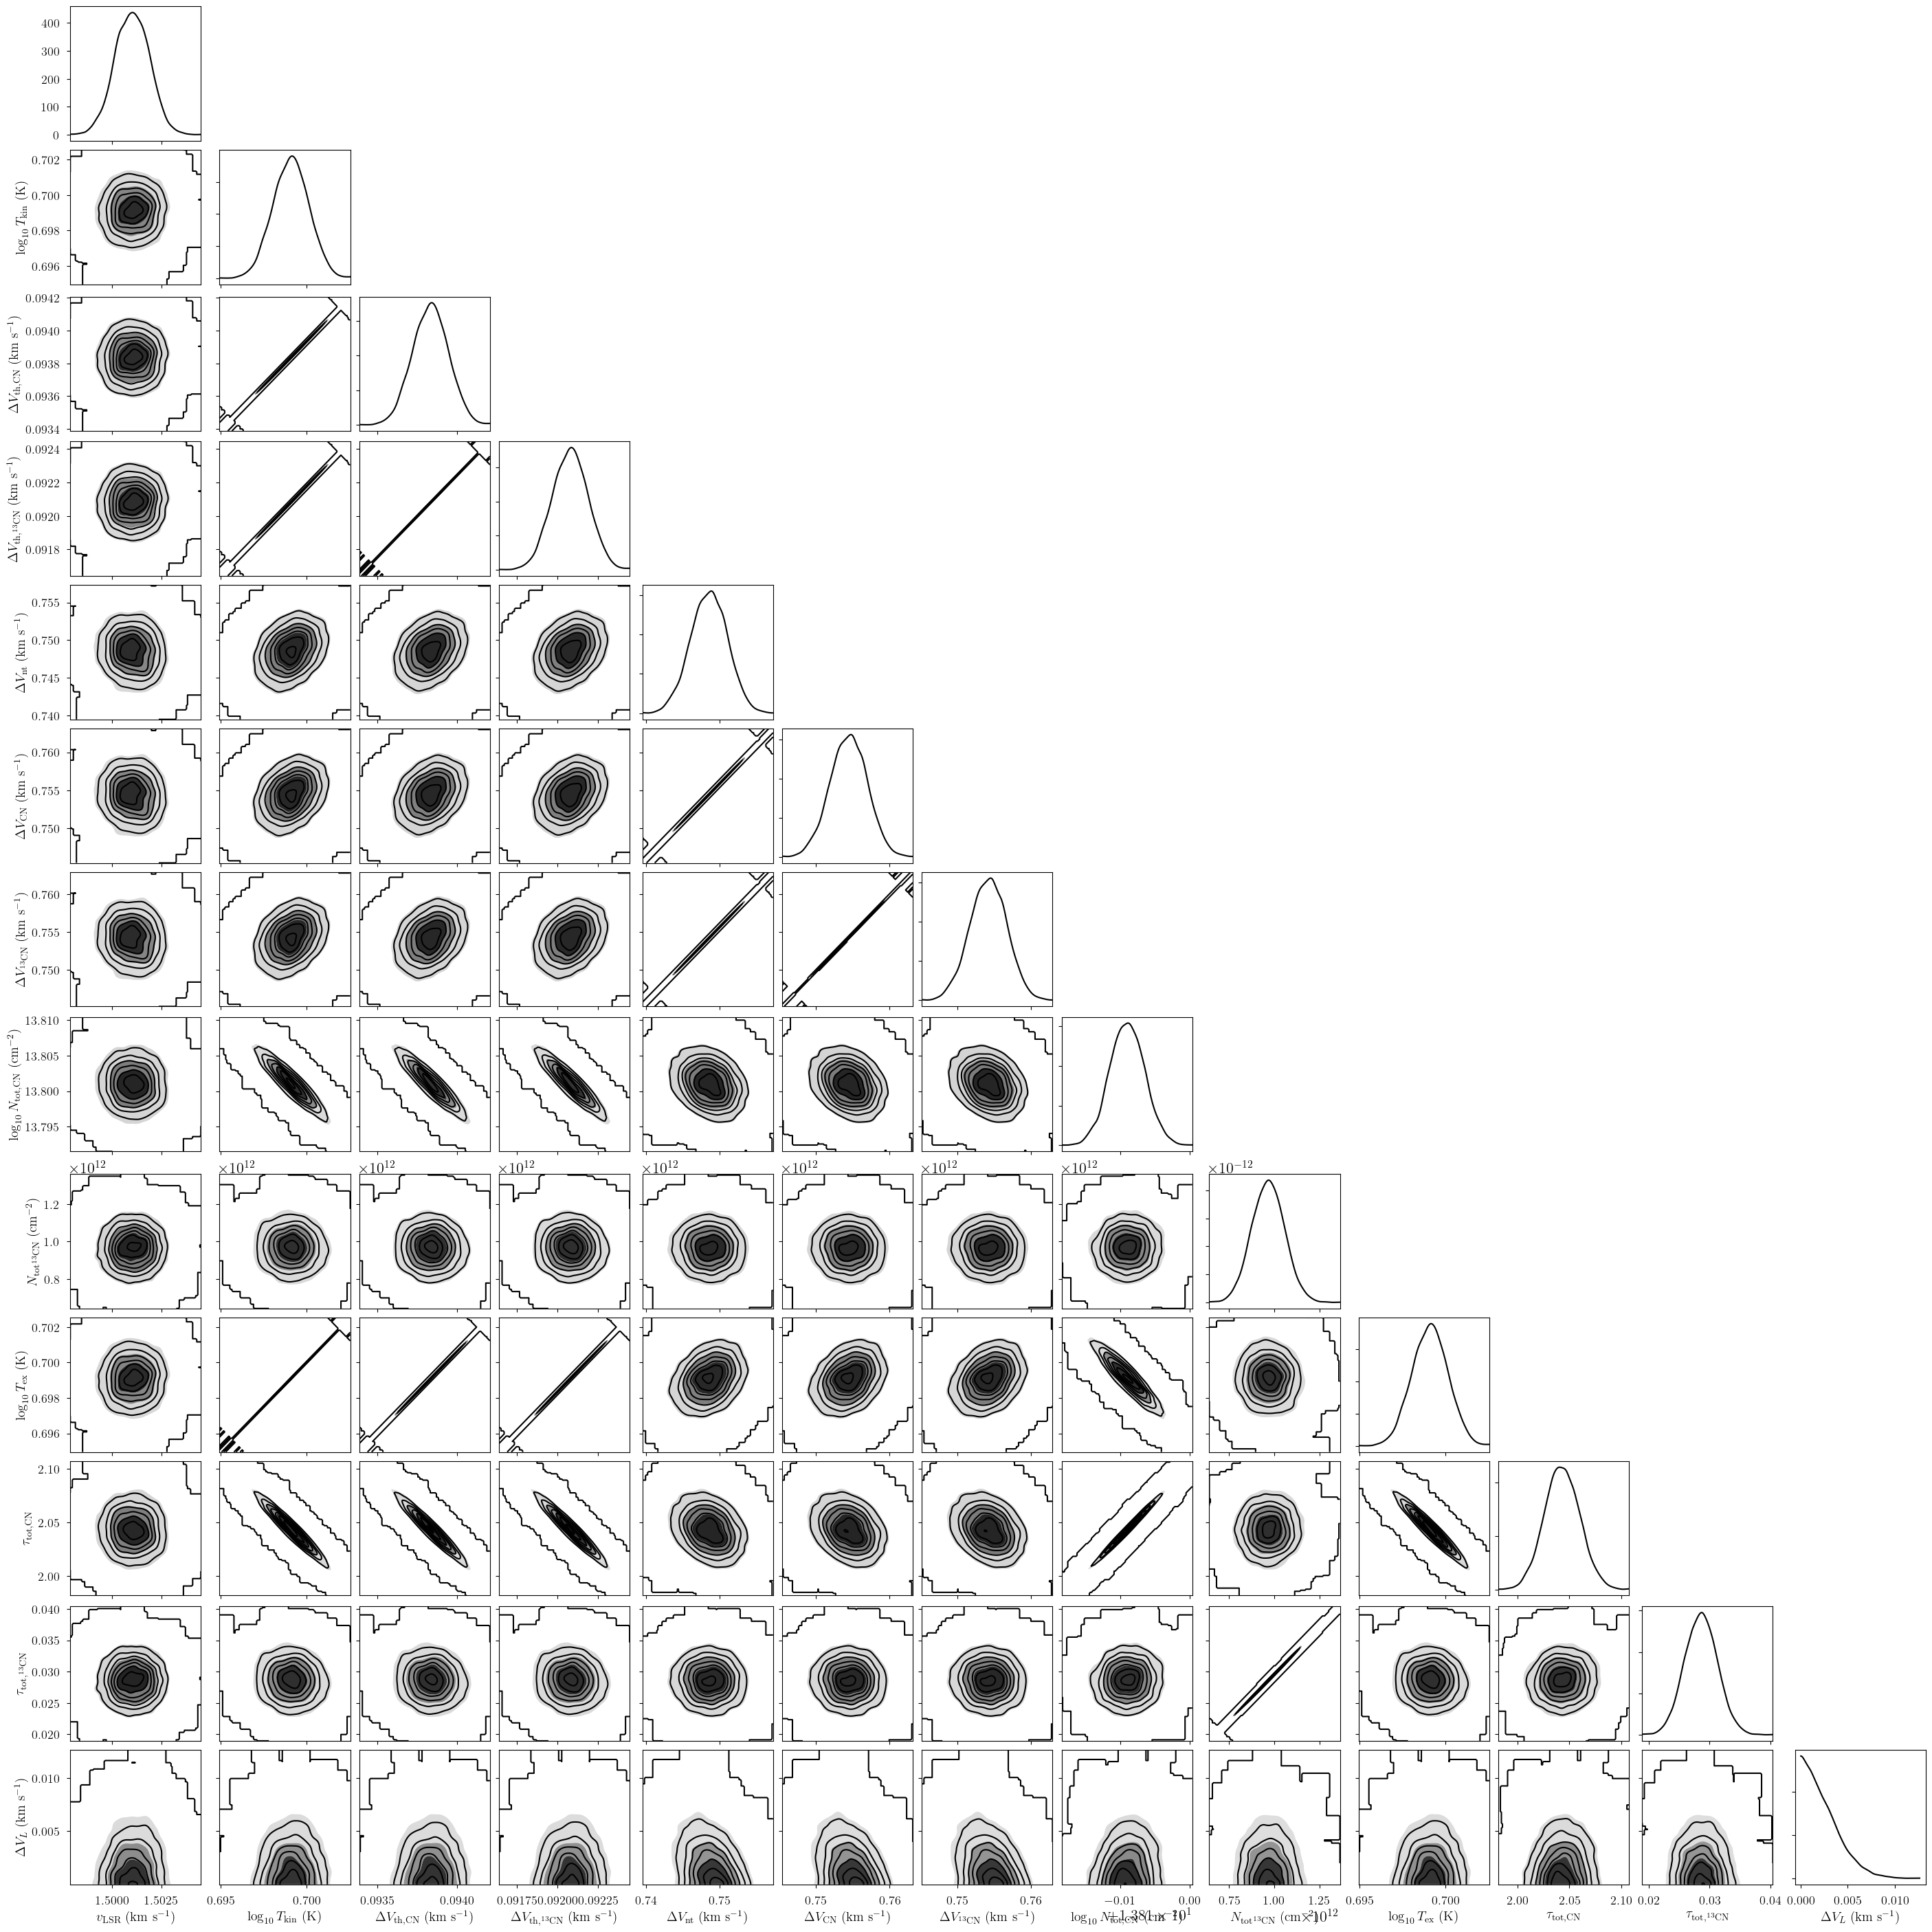

In [30]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

In [27]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -9605.89372774413


mean            sd       hdi_16%  \
velocity[0]              -5.000000e-01  1.000000e-03 -5.010000e-01   
velocity[1]               1.501000e+00  1.000000e-03  1.500000e+00   
log10_Tkin[0]             6.000000e-01  1.000000e-03  5.990000e-01   
log10_Tkin[1]             6.990000e-01  1.000000e-03  6.980000e-01   
fwhm_thermal_12CN[0]      8.400000e-02  0.000000e+00  8.400000e-02   
fwhm_thermal_12CN[1]      9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_13CN[0]      8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_thermal_13CN[1]      9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_nonthermal[0]        5.010000e-01  3.000000e-03  4.980000e-01   
fwhm_nonthermal[1]        7.490000e-01  2.000000e-03  7.460000e-01   
fwhm_12CN[0]              5.080000e-01  3.000000e-03  5.050000e-01   
fwhm_12CN[1]              7.540000e-01  2.000000e-03  7.520000e-01   
fwhm_13CN[0]              5.080000e-01  3.000000e-03  5.050000e-01   
fwhm_13CN[1]              7.540000e-01  2.000000e-03  7.520000e-01   
log10_N_12CN[0]           1.390000e+01  4.000000e-03  1.389600e+01   
log10_N_12CN[1]           1.380100e+01  2.000000e-03  1.379900e+01   
N_13CN[0]                 1.077461e+12  1.109476e+11  9.668670e+11   
N_13CN[1]                 9.662530e+11  9.010680e+10  8.752813e+11   
log10_Tex_ul[0]           6.000000e-01  1.000000e-03  5.990000e-01   
log10_Tex_ul[1]           6.990000e-01  1.000000e-03  6.980000e-01   
Tex_12CN[113123.3687, 0]  3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113123.3687, 1]  5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113144.19, 0]    3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113144.19, 1]    5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113170.535, 0]   3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113170.535, 1]   5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113191.325, 0]   3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113191.325, 1]   5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113488.142, 0]   3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113488.142, 1]   5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113490.985, 0]   3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113490.985, 1]   5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113499.643, 0]   3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113499.643, 1]   5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113508.934, 0]   3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113508.934, 1]   5.001000e+00  1.200000e-02  4.990000e+00   
Tex_12CN[113520.4215, 0]  3.981000e+00  7.000000e-03  3.975000e+00   
Tex_12CN[113520.4215, 1]  5.001000e+00  1.200000e-02  4.990000e+00   
tau_12CN[113123.3687, 0]  4.000000e-02  0.000000e+00  3.900000e-02   
tau_12CN[113123.3687, 1]  2.500000e-02  0.000000e+00  2.400000e-02   
tau_12CN[113144.19, 0]    3.240000e-01  3.000000e-03  3.210000e-01   
tau_12CN[113144.19, 1]    2.020000e-01  2.000000e-03  2.000000e-01   
tau_12CN[113170.535, 0]   3.170000e-01  3.000000e-03  3.130000e-01   
tau_12CN[113170.535, 1]   1.970000e-01  2.000000e-03  1.950000e-01   
tau_12CN[113191.325, 0]   4.110000e-01  4.000000e-03  4.070000e-01   
tau_12CN[113191.325, 1]   2.560000e-01  2.000000e-03  2.540000e-01   
tau_12CN[113488.142, 0]   4.130000e-01  4.000000e-03  4.090000e-01   
tau_12CN[113488.142, 1]   2.570000e-01  2.000000e-03  2.550000e-01   
tau_12CN[113490.985, 0]   1.097000e+00  1.100000e-02  1.085000e+00   
tau_12CN[113490.985, 1]   6.820000e-01  6.000000e-03  6.760000e-01   
tau_12CN[113499.643, 0]   3.260000e-01  3.000000e-03  3.220000e-01   
tau_12CN[113499.643, 1]   2.030000e-01  2.000000e-03  2.010000e-01   
tau_12CN[113508.934, 0]   3.180000e-01  3.000000e-03  3.150000e-01   
tau_12CN[113508.934, 1]   1.980000e-01  2.000000e-03  1.960000e-01   
tau_12CN[113520.4215, 0]  4.000000e-02  0.000000e+00  3.900000e-02   
tau_12CN[113520.4215, 1]  2.500000e-02  0.000000e+00  2.500000e-02   
tau_total_12CN[0]         3.286000e+00  3.40